In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re as re
import seaborn as sns
import datetime as dt
import openpyxl
import xlrd

**Ayiti Analytics Data Processing Bootcamp**

Ayiti Analytics Data wants to expand its training centers throughout all the communes of the country. Your role as a data analyst is to help them realize this dream.

Its objective is to know which three communes of the country will be the most likely to expand its training centers.

1. Knowing that each cohort must have 30 students

2. How many applications must be made to select 25% women for each on average

3. What are the most effective communication channels (Alumni, Facebook, WhatsApp, Friend ...) that will allow a student to be susceptible to selection

4. What is the average number of university students who should participate in this program

5. What will be the average number of applications per week that we could have?
How many weeks should we extend the application process to select 60 students per commune?
If we were to do all the bootcamp online, who would be the best communes and how many applications would we need to select 30 student and what percentage of students would have a laptop, an internet connection, both at the same time
6. What are the most effective communication channels (Alumni, Facebook, WhatsApp, Friend ...) that will allow a women to be susceptible to selection
NB
Use the same framework of the BA project to complete this project

In [50]:
commune=pd.read_excel(r"commune.xlsx")
enroll = pd.read_csv(r"enroll.csv")
quest = pd.read_csv(r"quest.csv")
industry = pd.read_csv(r"industry.csv")
ord = pd.read_csv(r"ord.csv")
study_domain = pd.read_csv(r"study_domain.csv")
transaction = pd.read_csv(r"transaction.csv")


In [51]:
def dummies_create(data, value):
  x=pd.get_dummies(data=data, columns=value, prefix="", prefix_sep="")
  y=x.groupby("quest_id").sum()
  return y

In [52]:
study_domain2 = dummies_create(study_domain[["key", "quest_id", "values"]], ["values"])
technology2 = dummies_create(technology[["key", "quest_id", "values"]], ['values'])
industry2 = dummies_create(industry[["key", "quest_id", "values"]], ['values'])

In [53]:
quest.drop(['Unnamed: 0', 'modified_at',"study_domain", 'department'], axis=1, inplace = True)
quest.rename(columns={'created_at':"signup_date", 'hear_AA_1': "chanels", "after_AA":"Project" },inplace = True )
quest["signup_date"] = quest["signup_date"].str[:10]
print(f"The number of appliants in the bootcamp is {len(quest)}.")

The number of appliants in the bootcamp is 250.


In [54]:
quest["dob"].replace({"3 aout 1977": "3/08/1977"}, inplace=True)
quest["dob"] = pd.to_datetime(quest["dob"])
quest["signup_date"] = pd.to_datetime(quest["signup_date"])

In [55]:
quest["age"] = (-(quest["dob"]-quest["signup_date"])//365)
quest["age"] = quest["age"].apply(lambda x: str(x)[:2])
age=quest["age"].tolist()
age = [0 if val == "Na" else val for val in age]
age = [int(val) for val in age]
age = [sum(age)/len(age) if (val == 0 or val == 1.0 or val ==-1.0) else val for val in age]
quest["age"]= age

In [56]:
ord["paid"] = "Carte"
transaction["paid"] = "MonCash"
print(f"{len(enroll)} people enrolled in the course Introduction to Data Science, {len(ord)} paid by credit card and {len(transaction)} paid by moncash." )
print("We notice that not all enrolled necessarly apply for the bootcamp.")

148 people enrolled in the course Introduction to Data Science, 18 paid by credit card and 60 paid by moncash.
We notice that not all enrolled necessarly apply for the bootcamp.


In [57]:
data = pd.merge(left = enroll, right = ord, how="left", on="quest_id")
#dta = pd.merge(left = data, right = transaction, how="left", on="user_id")
#d = pd.merge(left=quest, right=dta, how = "left", on="quest_id")
#print(data.info())

In [58]:
commune["Commune_Id"] = commune["Commune_Id"].str.lower()
commune.rename(columns = {"Commune_Id": "commune"}, inplace = True)

In [59]:
result=pd.merge(left=quest, right=enroll[["percentage_completed","completed", "quest_id"]], how = 'left',on='quest_id')
result=pd.merge(left=result, right=study_domain2, how = 'left',on='quest_id')
result=pd.merge(left=result, right=technology2, how = 'left',on='quest_id')
result=pd.merge(left=result, right=industry2, how = 'left',on='quest_id')
result=pd.merge(left=result, right=commune[["Commune_FR","Departement", "commune"]], how = 'left',on='commune')
result.head(2)

,gender,dob,commune,signup_date,education_level,university,current_employed,formal_sector_job,have_computer_home,internet_at_home,chanels,Project,quest_id,age,percentage_completed,completed,Accounting,Computer Science,Economics,Electrical Engineering,Law,Management,Medicine,Statistics,other_x,Bash,Excel,Git,Java,JavaScript,PHP,PowerBI or Tableau,Python,R,SQL,VBA,other_y,Communications,Consulting,Education,Energy,Finance,Healthcare,Insurance,Manufacturing,Marketing,Public Sector/ Non-Profit Agencies,Retail/ E-Commerce,Technology (Software/ Internet),Transportation,other,Commune_FR,Departement
0,male,1998-08-25,ht0111,2021-02-14,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,905dc006-ce95-11eb-b2f9-7c67a234f601,22.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Port-au-Prince,West
1,female,1996-09-29,ht0111,2021-02-16,Bachelors (bacc +4),other,No,unknown,Yes,Yes,Friend,Finding a job/internship,905ddcf2-ce95-11eb-9a92-7c67a234f601,24.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Port-au-Prince,West


In [60]:
ord.head(2)
ord1 = ord.rename(columns = {'created_at': 'createdord'}, inplace = True)
transaction.rename(columns = {'created_at': 'createdtrans'}, inplace = True)
print(transaction.columns)
ord.head(2)

Index(['Unnamed: 0', 'createdtrans', 'modified_at', 'user_id', 'course_id',
       'transaction_id', 'paid'],
      dtype='object')


,Unnamed: 0,createdord,user_id,product_name,product_id,amount_dollars,amount_cents,subscription,coupon_code,coupon_id,affiliate_referral_code,status,quest_id,paid
0,0,2021-03-14T15:34:35.014Z,41587952,Entwodiksyon Nan Syans Done,1100636,20,2000,False,NaN,NaN,NaN,Complete,906b3c86-ce95-11eb-b6a7-7c67a234f601,Carte
1,1,2021-03-14T04:20:23.483Z,41564742,Entwodiksyon Nan Syans Done,1100636,20,2000,False,NaN,NaN,NaN,Complete,906636cf-ce95-11eb-8679-7c67a234f601,Carte


In [61]:
result["male"] = result["gender"].apply(lambda x: 1 if x == "male" else 0)
result["female"] = result["gender"].apply(lambda x: 1 if x == "female" else 0)
gender = pd.DataFrame()
gender["male"]=[result["male"].sum()]
gender["female"]=[result["female"].sum()]
gender

,male,female
0,203,47


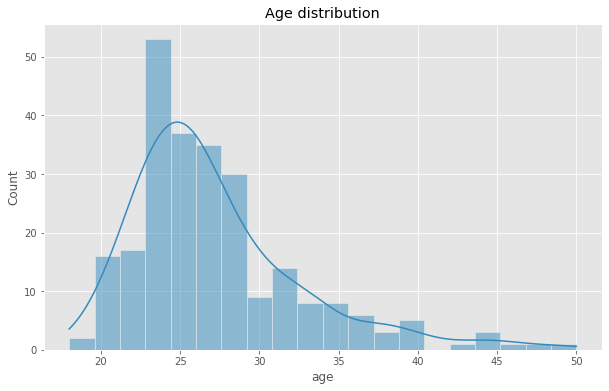

In [62]:
plt.figure(figsize=(10,6))
sns.histplot(data = quest,x=quest["age"],kde=True,bins=20)
plt.title("Age distribution")
plt.show()

Most of the applicants are under 30 years old, we can say in particular that those aged from 22 to 28 years are very represented and are very interested in data science.

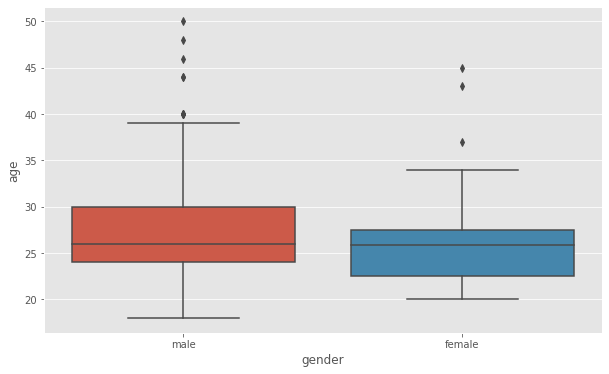

In [63]:
plt.figure(figsize=(10,6))
sns.boxplot(data=quest,x="gender",y="age")
#quest[quest["age"]<10]

**The age distribution of men and women does not differ greatly.** The The median is almost identical and would be around 28 years.

Text(0, 0.5, 'Technologies')

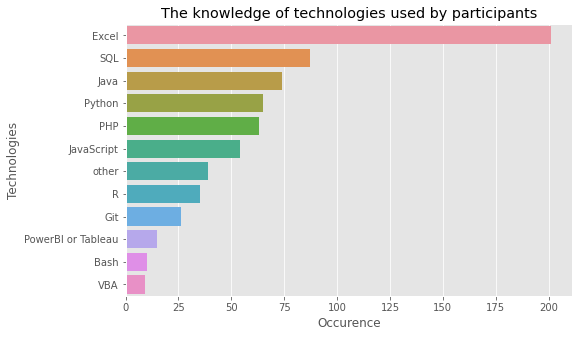

In [64]:
technology1 = technology2.reset_index()
tech1 = technology1.drop(["quest_id"], inplace=False, axis=1).sum(axis=0)
tech1 = tech1.sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(y=tech1.index, x = tech1)
plt.title("The knowledge of technologies used by participants")
plt.xlabel("Occurence")
plt.ylabel("Technologies")

**Excel** is the most used tool among the applicants.

Text(0, 0.5, 'Domains')

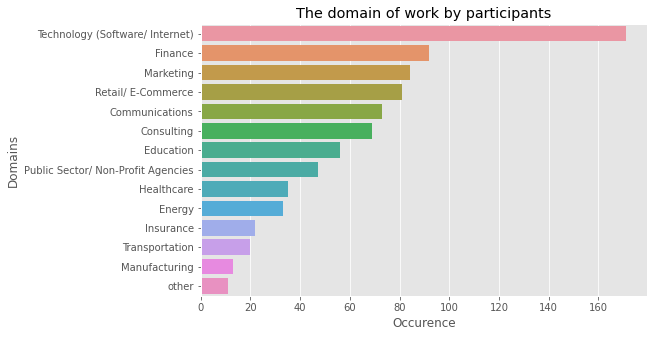

In [65]:
industry1 = industry2.reset_index()
indus1 = industry1.drop(["quest_id"], inplace=False, axis=1).sum(axis=0)
indus1 = indus1.sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(y=indus1.index, x = indus1)
plt.title("The domain of work by participants")
plt.xlabel("Occurence")
plt.ylabel("Domains")

**Technology(software/internet) and finance** seem to be the domains of work most found among the applicants.

Text(0, 0.5, 'Domains of study')

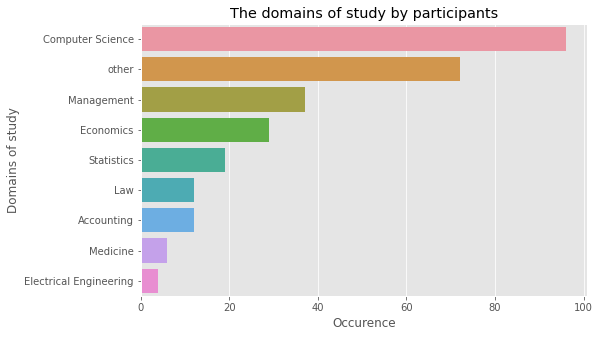

In [66]:
study_domain1 = study_domain2.reset_index()
stud1 = study_domain1.drop(["quest_id"], inplace=False, axis=1).sum(axis=0)
stud1 = stud1.sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(y=stud1.index, x = stud1)
plt.title("The domains of study by participants")
plt.xlabel("Occurence")
plt.ylabel("Domains of study")

**Computer science** are the domain of study better represented. We know how much diversity is important for AA.

In [67]:
def generate_barchart(data="", title ="",abs_value ="Total",rel_value="Percent",figsize =(7,3),horizontal=""):
  plt.figure(figsize=figsize)
  plt.style.use("ggplot")
  axes = sns.barplot(data=data,x=data.index,y=abs_value)
  i=0
  for tot, perc in zip(data[abs_value],data[rel_value]):
    axes.text(i,
              tot/2,
              str(np.round(perc*100,2))+ "%",
               fontdict=dict(color='White',fontsize=12,horizontalalignment="center")
              )
    axes.text(i,
              tot+ 3,
              str(tot),
               fontdict=dict(color='blue',fontsize=12,horizontalalignment="center")
              )
    
    i+=1
  plt.title(title)
  plt.show()

The three city with most applicants are : 
                qty   freq
Commune_FR                
Delmas           71  0.284
Port-au-Prince   59  0.236
Pétion-Ville     29  0.116
We could consider them beacause we suppose that no bootcamp have been already done anywhere.


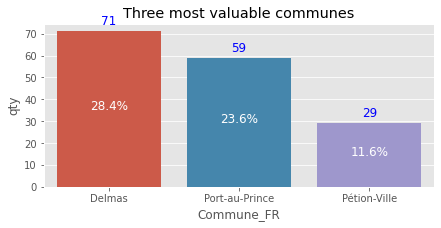

In [68]:
df1 = result.groupby("Commune_FR")["quest_id"].nunique().to_frame(name='qty').sort_values(ascending=False, by="qty")
df1["freq"] = df1["qty"]/df1["qty"].sum()
print(f"The three city with most applicants are : \n{df1.head(3)}")
print("We could consider them beacause we suppose that no bootcamp have been already done anywhere.")

generate_barchart(data=df1.head(3),title="Three most valuable communes",abs_value="qty", rel_value='freq')

In [69]:
def pivotabl(x):
  new_pivot=pd.pivot_table(result, values='quest_id', 
                    index=['Commune_FR'], 
                    columns=x,
                    aggfunc='count')
  new_pivot=new_pivot.fillna(0)
  #new_pivot.drop(["unkwown", "other", "Other"],axis=1, inplace=True)
  return new_pivot

In [70]:
pv_gender=pivotabl("gender")
pv_edulevel = pivotabl("education_level")
Chanel = pivotabl("chanels")
Project = pivotabl('Project')
pv_internet = pivotabl("internet_at_home")
pv_computer = pivotabl("have_computer_home")
pv_employed = pivotabl('current_employed')
pv_internet.rename(columns={"No":"Don't have internet", "Yes":"Have internet"}, inplace=True)
pv_computer.rename(columns={"No":"Don't have computer", "Yes":"Have computer"}, inplace=True)
pv_employed.rename(columns={"No":"Don't be employed", "Yes":"Employed"}, inplace=True)

In [71]:
data_commune = pd.concat([pv_gender, pv_edulevel, Chanel, Project, pv_internet, pv_computer, pv_employed], axis=1)
data_commune["qty"]=result.groupby("Commune_FR")["quest_id"].nunique().sort_values()
#data_commune.to_frame(name="qty").sort_values(by=['qty'])
data_commune.sort_values(by=["qty"], inplace=True, ascending=False)
data_commune5 = data_commune[data_commune.qty>5]
print("this dataframe contains the data for each commune with the number of applicants for each variable, it can allow us to see the best prepared communes in number of applicants")
data_commune5

this dataframe contains the data for each commune with the number of applicants for each variable, it can allow us to see the best prepared communes in number of applicants


,female,male,Bachelors (bacc +4),"Doctorate (PhD, MD, JD)",High School (16 years),Masters,Other,unknown,Ayiti Analytics Website,Bootcamp Alumni,ESIH,Facebook,Friend,Instagram,LinkedIn,WhatsApp,other,unknown,Finding a job/internship,Improving my data analysis skills,Mentorship,Switching careers,Training to start my own company,other,unknown,Don't have internet,Have internet,unknown,Don't have computer,Have computer,unknown,Don't be employed,Employed,unknown,qty
Commune_FR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Delmas,12.0,59.0,41.0,1.0,8.0,5.0,16.0,0.0,5.0,6.0,7.0,4.0,25.0,3.0,6.0,14.0,1.0,0.0,15.0,37.0,3.0,5.0,10.0,0.0,1.0,10.0,61.0,0.0,5.0,66.0,0.0,50.0,20.0,1.0,71
Port-au-Prince,19.0,40.0,29.0,0.0,9.0,4.0,14.0,3.0,2.0,4.0,6.0,9.0,12.0,0.0,5.0,17.0,3.0,1.0,11.0,26.0,5.0,6.0,8.0,2.0,1.0,6.0,52.0,1.0,1.0,57.0,1.0,41.0,17.0,1.0,59
Pétion-Ville,4.0,25.0,20.0,0.0,3.0,1.0,5.0,0.0,3.0,0.0,2.0,5.0,8.0,1.0,0.0,9.0,1.0,0.0,3.0,17.0,2.0,3.0,4.0,0.0,0.0,3.0,25.0,1.0,4.0,25.0,0.0,22.0,6.0,1.0,29
Carrefour,6.0,17.0,17.0,0.0,3.0,1.0,2.0,0.0,2.0,4.0,0.0,5.0,7.0,0.0,0.0,4.0,1.0,0.0,3.0,14.0,0.0,1.0,4.0,1.0,0.0,5.0,18.0,0.0,2.0,21.0,0.0,19.0,4.0,0.0,23
Tabarre,3.0,8.0,7.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,3.0,1.0,0.0,1.0,8.0,0.0,0.0,2.0,0.0,0.0,2.0,9.0,0.0,0.0,11.0,0.0,10.0,1.0,0.0,11
Croix-Des-Bouquets,0.0,10.0,4.0,0.0,3.0,1.0,2.0,0.0,1.0,0.0,1.0,2.0,4.0,1.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,1.0,3.0,0.0,0.0,2.0,8.0,0.0,0.0,10.0,0.0,9.0,1.0,0.0,10


In [72]:
data_commune5.drop(["unknown", "other", "Other"], axis=1, inplace=True, )
data_commune5.columns

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['female', 'male', 'Bachelors (bacc +4)', 'Doctorate (PhD, MD, JD)',
       'High School (16 years)', 'Masters', 'Ayiti Analytics Website',
       'Bootcamp Alumni', 'ESIH', 'Facebook', 'Friend', 'Instagram',
       'LinkedIn', 'WhatsApp', 'Finding a job/internship',
       'Improving my data analysis skills', 'Mentorship', 'Switching careers',
       'Training to start my own company', 'Don't have internet',
       'Have internet', 'Don't have computer', 'Have computer',
       'Don't be employed', 'Employed', 'qty'],
      dtype='object')

The profil of the applicants of the AAB 2021

In [73]:
plt.style.use("ggplot")

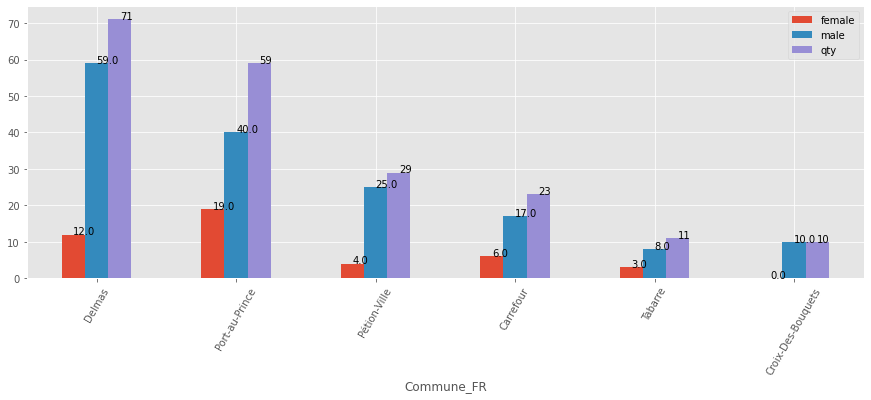

In [74]:
dat_commune = data_commune[["female", "male", "qty"]].reset_index()
#dat_commune.reset_index()
fig, ax = plt.subplots(figsize=(15,5))
dat_commune.head(6).plot.bar(x = 'Commune_FR', y = ['female', 'male', "qty"], rot = 60, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

The minimum number of applicants required to ensure that there are at least 8 women

In [75]:
pv = data_commune[["qty", "male", "female"]]
pv["women freq"] = (pv["female"]/pv["qty"])
pv["Min_App"] = round(8/pv["women freq"], 0)
pv = pv.reset_index()
pv = pv.head(6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
for i in [0,1,2,4,5]:
   a= pv.at[i,"Commune_FR"]
   b= pv.at[i,"qty"]
   c= pv.at[i,"female"]
   d= pv.at[i,"Min_App"]
   print(f"In {a}, we have {b} applicants including {c} women, if we want to be sure we have 8 women, 25% of 30 \nWe have to receive at least {d} applicants.")
print("We notice that for Croix-Des-Bouquets, we had 0 woman, so we can predict for how many applicants, we'll have 8 women.")

In Delmas, we have 71 applicants including 12.0 women, if we want to be sure we have 8 women, 25% of 30 
We have to receive at least 47.0 applicants.
In Port-au-Prince, we have 59 applicants including 19.0 women, if we want to be sure we have 8 women, 25% of 30 
We have to receive at least 25.0 applicants.
In Pétion-Ville, we have 29 applicants including 4.0 women, if we want to be sure we have 8 women, 25% of 30 
We have to receive at least 58.0 applicants.
In Tabarre, we have 11 applicants including 3.0 women, if we want to be sure we have 8 women, 25% of 30 
We have to receive at least 29.0 applicants.
In Croix-Des-Bouquets, we have 10 applicants including 0.0 women, if we want to be sure we have 8 women, 25% of 30 
We have to receive at least inf applicants.
We notice that for Croix-Des-Bouquets, we had 0 woman, so we can predict for how many applicants, we'll have 8 women.


In [77]:
#signup_per_week=result5[["Date d'inscription","quest_id"]].groupby(pd.Grouper(key="Date d'inscription",freq='7D')).count()
signup_per_week = result[["signup_date","quest_id", "male","female"]].groupby(pd.Grouper(key="signup_date",freq='7D')).sum()


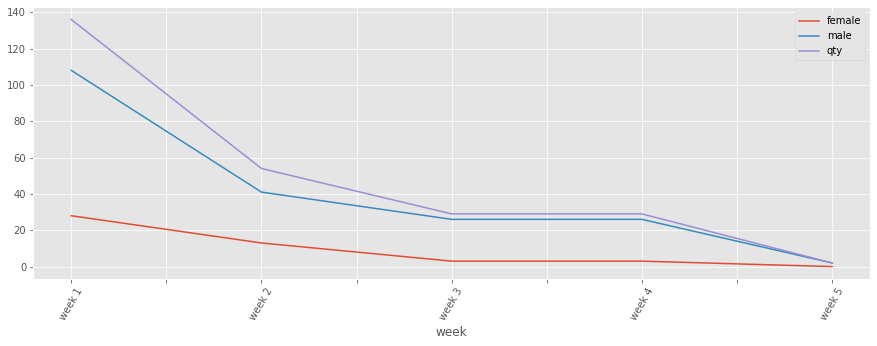

In [78]:
signup_per_week["qty"]=result[["signup_date","quest_id", ]].groupby(pd.Grouper(key="signup_date",freq='7D')).count()
signup_per_week["week"] = ["week 1", "week 2", "week 3", "week 4", "week 5"]
fig, ax = plt.subplots(figsize=(15,5))
signup_per_week.plot.line(x = 'week', y = ['female', 'male', "qty"], rot = 60, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))
 #montre qu'une prolongation de la date d'inscription ne fait pas augmenter les sign up.

We can see from this graph that **increasing the number of days will not increase the number of registrations**, the best strategy would be to use the **most used channels to attract the most applicants**.



In [79]:
gend_chan = pd.crosstab(result["gender"], result["chanels"], margins=True)
gend_chan

chanels,Ayiti Analytics Website,Bootcamp Alumni,ESIH,Facebook,Friend,Instagram,LinkedIn,WhatsApp,other,unknown,All
gender,,,,,,,,,,,
female,4,8,5,6,11,1,1,9,2,0,47
male,11,6,13,34,56,4,14,57,7,1,203
All,15,14,18,40,67,5,15,66,9,1,250


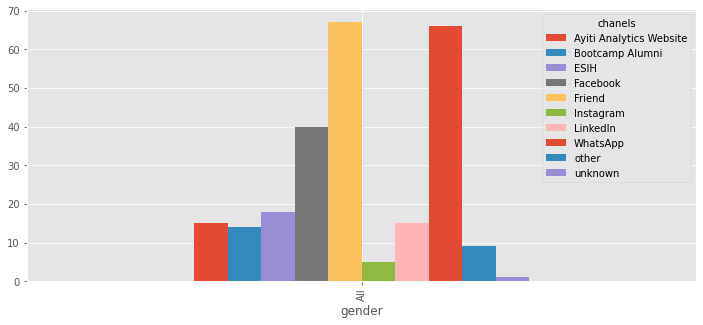

In [80]:
plot1 = gend_chan.iloc[2:3, :-1].plot(kind="bar", figsize=(12,5))

The best chanels to use to attract applicants are **Friends and Whatsapp**, we can say that way of the way to get more is to use networking. This does not mean that the best channel for all applicants is the same for each gender independently. We know how much AA want to **reduce the inequality between men and women in Data Science Domain.**

In [81]:
gend_chanels = gend_chan[["Ayiti Analytics Website", "Bootcamp Alumni", "ESIH", "Facebook","Friend","LinkedIn","WhatsApp" ]]
gend_chanels=gend_chanels.to_numpy().T[:,:2]
gend_chanels
from scipy.stats import chi2_contingency
chi2, pval, dof, expected = chi2_contingency(gend_chanels)
print(f"The p=value is {round(pval, 4)}< 0.05, so With a significance level of 0.05,\nwe can therefore conclude that the association between the variables Gender and Channels is statistically significant.")
print("We can propose to see the specific chanels to encourage womwn to apply")

The p=value is 0.0055< 0.05, so With a significance level of 0.05,
we can therefore conclude that the association between the variables Gender and Channels is statistically significant.
We can propose to see the specific chanels to encourage womwn to apply


In [82]:
w = []
m = []
for i in range(10):
  a = (gend_chan.iloc[0:1,i:i+1].to_numpy()).tolist()[0][0]
  w.append(a)
for i in range(10):
  b = (gend_chan.iloc[1:2,i:i+1].to_numpy()).tolist()[0][0]
  m.append(b)
for i in range(9):
  if w[i]>m[i]:
    loc = gend_chan.columns[i]
    print(f"The number of women for the {loc} is bigger tan for men, \nand we should use this chanel to get more women.")

The number of women for the Bootcamp Alumni is bigger tan for men, 
and we should use this chanel to get more women.


 If we use the others, we'll get more men because they attract men more tan women. The more efficient chanel that could attract women more than men is **Bootcamp Alumni**. The women are most likely confident to people who have been through the experience.

In [83]:
result["scor1"] = result["have_computer_home"].apply(lambda x: 0.6 if x=="Yes" else 0)
result["scor2"] = result['internet_at_home'].apply(lambda x: 0.4 if x=="Yes" else 0)
result["tot_sc"] = result["scor1"]+result["scor2"]

In [84]:
df3 = pd.DataFrame()
df3["scor"] = result.groupby("Commune_FR")["tot_sc"].sum().sort_values(ascending=False)
df3["qty"]=result.groupby("Commune_FR")["quest_id"].nunique()
df3 = df3[df3['qty']>5]
df3["moy"]=df3["scor"]/df3["qty"]
df3

,scor,qty,moy
Commune_FR,,,
Delmas,64.0,71,0.901408
Port-au-Prince,55.0,59,0.932203
Pétion-Ville,25.0,29,0.862069
Carrefour,19.8,23,0.860870
Tabarre,10.2,11,0.927273
Croix-Des-Bouquets,9.2,10,0.920000


We calculated scores for each individual based on whether or not they have a computer at home and whether or not they have access to the internet. We show the score for the top five commune with more applicants, we find that Port au Prince, Tabarre and Croix-des-Bouquest. We do not take the 30 person criterion as relevant given the virtual aspect. **Since the bootcamp will be conducted online, it is not at all important to take into account the residence of the applicant. We take it as long as it is technically equipped no matter where he is located.**


In [89]:
listboth = []
for c in df3.index:
  df = result[result.Commune_FR== c]
  df["both"] = df.have_computer_home.apply(lambda x: 1 if x=="Yes" else 0) + df["internet_at_home"].apply(lambda x: 1 if x=="Yes" else 0)
  g = df["both"].apply(lambda x: 1 if x==2 else 0)
  n = g.sum()
  print(f"{c} has {n} people who have both computer and internet.\n")


Delmas has 58 people who have both computer and internet.

Port-au-Prince has 52 people who have both computer and internet.

Pétion-Ville has 21 people who have both computer and internet.

Carrefour has 17 people who have both computer and internet.

Tabarre has 9 people who have both computer and internet.

Croix-Des-Bouquets has 8 people who have both computer and internet.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [86]:
for c in data_commune5.index:
   i = data_commune5.at[c, "qty"]
   j = data_commune5.at[c, "Have internet"]
   o = data_commune5.at[c, "Don't have internet"]
   l = data_commune5.at[c, "Have computer"]
   t = data_commune5.at[c, "Don't have computer"]
   print(f"{c} has {i} applicants, {j} have internet and {o} don't have \n{l} have computer and {t} don't have. \n")


Delmas has 71 applicants, 61.0 have internet and 10.0 don't have 
66.0 have computer and 5.0 don't have. 

Port-au-Prince has 59 applicants, 52.0 have internet and 6.0 don't have 
57.0 have computer and 1.0 don't have. 

Pétion-Ville has 29 applicants, 25.0 have internet and 3.0 don't have 
25.0 have computer and 4.0 don't have. 

Carrefour has 23 applicants, 18.0 have internet and 5.0 don't have 
21.0 have computer and 2.0 don't have. 

Tabarre has 11 applicants, 9.0 have internet and 2.0 don't have 
11.0 have computer and 0.0 don't have. 

Croix-Des-Bouquets has 10 applicants, 8.0 have internet and 2.0 don't have 
10.0 have computer and 0.0 don't have. 

